![](../images/gmm2.png)

In [9]:
from __future__ import print_function
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from matplotlib import pyplot
# %matplotlib inline
pyro.enable_validation(True)

In [10]:
data = torch.tensor([0., 1., 10., 11., 12.])
K = 2  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

<h3><span class="header-section-number">4.3.3</span> Review of Approximate Inference</h3>
<p>We have variables <span class="math inline">\(Z\)</span>s (cluster assignments) and <span class="math inline">\(X\)</span>s (data points) in our mixture model, where <span class="math inline">\(X\)</span> is observed and <span class="math inline">\(Z\)</span> is latent (unobserved). As we saw earlier, a generative model entails a joint distribution <span class="math display">\[p(Z,X)\]</span></p>
<p>Inference of unknown can be achieved through conditioning on the observations.</p>
<p><span class="math display">\[p(Z \mid X) = \frac{p(Z, X)}{p(X)}\]</span></p>
<p>And for the most interesting problems, the integral for the denominator(marginal) is not tractable. <span class="math display">\[p(X) = \int dZp(X \mid Z)p(Z)\]</span></p>
<p>So we have to directly approximate <span class="math inline">\(p(Z \mid X)\)</span>. There are two ways of approximate this posterior.</p>
<ol style="list-style-type: decimal">
<li>Sampling methods like Gibbs sampler.</li>
<li>Variational inference.</li>
</ol>
</div>
<div id="variational-inference" class="section level3">
<h3><span class="header-section-number">4.3.4</span> Variational Inference:</h3>
<p>We can’t compute <span class="math inline">\(p(Z \mid X)\)</span> directly, so let’s approximate with some other distribution <span class="math inline">\(q(Z; \nu)\)</span> over Z that is tractable (for example, Gaussions or other exponential family).</p>
<div class="figure">
<img src="../images/VI1.png" alt="Image" />
<p class="caption">Image</p>
</div>
<p><a href="https://www.youtube.com/watch?v=ogdv_6dbvVQ"><span class="math display">\[\texttt{David Blei - Variational Inference (NeurIPS 2016 Tutorial)}\]</span></a></p>
<p>Since q is tractable, we can play with it’s parameter <span class="math inline">\(\nu\)</span> such that it reaches as close to <span class="math inline">\(p(Z\mid X)\)</span> as possible. More precisely, we want to minimize the KL divergence between <span class="math inline">\(q\)</span> and <span class="math inline">\(p\)</span>. With this trick, we just turned an <strong>inference</strong> problem to an <strong>optimization</strong> problem!</p>
<p><span class="math display">\[
\begin{align*}
KL(q(Z;\nu) \mid\mid p(Z\mid X)) &amp;= -\int dZ\ q(Z) \log\frac{P(Z\mid X)}{q(Z)}\\
&amp;= -\int dZ\ q(Z) \log 
\frac{\frac{p(Z,X)}{p(X)}}{q(Z)}\\
&amp;= -\int dZ\ q(Z) \log 
\frac{p(Z,X)}{p(X)q(Z)}\\
&amp;= -\int dZ\ q(Z) 
\left[
\log 
\frac{p(Z,X)}{q(Z)}
- \log p(X)
\right]\\
&amp;= - \int dZ\ \log \frac{p(Z,X)}{q(Z)} + \underbrace{\int dZ\ q(Z)}_{\text{=1}}\log p(X)\\
&amp;= - \int dZ\ \log \frac{p(Z,X)}{q(Z)} + \log p(X)\\
\log p(X) &amp;= KL(q(Z;\nu)\mid\mid p(Z\mid X) + \underbrace{\int dZ\ q(Z;\nu) \log \frac{p(Z,X)}{q(Z;\nu)}}_{\mathcal{L}}\\
\end{align*}
\]</span></p>
<p>Note that we already observed <span class="math inline">\(X\)</span> and we conditioned the model to get <span class="math inline">\(p(Z \mid X)\)</span>. But given <span class="math inline">\(X\)</span>, <span class="math inline">\(\log p(X)\)</span> is constant! So, minimizing KL is equivalent to maximizing <span class="math inline">\(\mathcal{L}\)</span>.</p>
<p><strong>How do you maximize <span class="math inline">\(\mathcal{L}\)</span></strong>? Take <span class="math inline">\(\nabla_{\nu} \mathcal{L}\)</span>.</p>
<p><span class="math inline">\(\mathcal{L}\)</span> is called <strong>variational lower bound</strong>. It is often called ELBO.</p>
<p><strong>Stochastic Variational Inference</strong> scales variational inference to massive data. Just like in stochastic variational inference, you subsample the data and update the posterior!</p>
<!-- #region -->
</div>
<div id="stochastic-optimization" class="section level3">
<h3><span class="header-section-number">4.3.5</span> Stochastic Optimization</h3>
<p>In stochastic optimization, we replace the gradient with cheaper noisy estimate which is guranteed to converge to a local optimum.</p>
<p><span class="math display">\[\nu_{t+1} = \nu_t + \rho_t \hat{\nabla}_{\nu} \mathcal{L}(\nu_t)\]</span></p>
<p>Requirements:</p>
<ul>
<li><p>Unbiased gradients, i.e. <span class="math display">\[\mathbb{E}[\hat{\nabla}_{\nu} \mathcal{L}(\nu_t)] = \nabla_{\nu}\mathcal{L}(\nu)\]</span></p></li>
<li><p>Step-size sequence <span class="math inline">\(\rho_t\)</span> that follows Robbins-Monro conditions.</p></li>
</ul>
<p>Stochastic variational inference takes inspiration from stochastic optimization and natural graidient. We follow the same procedure as stochastic gradient descent. <!-- #endregion --></p>
</div>
<div id="a-rough-stochastic-variational-inference-algorithm" class="section level3">
<h3><span class="header-section-number">4.3.6</span> A Rough Stochastic variational inference algorithm:</h3>
<ul>
<li>Initialize <span class="math inline">\(q\)</span> with some <span class="math inline">\(\nu\)</span></li>
<li>Until Converge:
<ul>
<li>subsample from Data:
<ul>
<li>compute gradient <span class="math inline">\(\hat{\nabla_{\nu}}\mathcal{L}_{\nu_t}\)</span></li>
<li>update global parameter <span class="math inline">\(\nu_{t+1} = \nu_t + \rho_t \hat{\nabla_{\nu}}\mathcal{L}_{\nu_t}\)</span></li>
</ul></li>
</ul></li>
<li>Return <span class="math inline">\(q(Z;\nu)\)</span></li>
</ul>
</div>
<div id="training-a-map-estimator" class="section level3">
<h3><span class="header-section-number">4.3.7</span> Training a MAP estimator</h3>
<p>Let’s start by learning model parameters <code>weights</code>, <code>locs</code>, and <code>scale</code> given priors and data. We will use <code>AutoDelta</code> guide function. Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components.</p>
<p>During inference, <code>TraceEnum_ELBO</code> will marginalize out the assignments of datapoints to clusters.</p>
<p><code>max_plate_nesting</code> lets Pyro know that we’re using the rightmost dimension plate and that Pyro can use any other dimension for parallelization.</p>
</div>
</div>
<div id="some-other-pyro-vocabulary" class="section level2">
<h2><span class="header-section-number">4.4</span> Some other Pyro vocabulary</h2>
<ul>
<li>poutine - Beneath the built-in inference algorithms, Pyro has a library of composable effect handlers for creating new inference algorithms and working with probabilistic programs. Pyro’s inference algorithms are all built by applying these handlers to stochastic functions.
<ul>
<li>poutine.block - blocks pyro premitives. By default, it blocks everything.</li>
</ul></li>
<li><p>param - Parameters in Pyro are basically thin wrappers around PyTorch Tensors that carry unique names. As such Parameters are the primary stateful objects in Pyro. Users typically interact with parameters via the Pyro primitive <code>pyro.param</code>. Parameters play a central role in stochastic variational inference, where they are used to represent point estimates for the parameters in parameterized families of models and guides.</p></li>
<li><p>param_store - Global store for parameters in Pyro. This is basically a key-value store.</p></li>

In [11]:
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [12]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss

In [13]:
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 7, initial_loss = 25.665584564208984


In [14]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
losses = []
for i in range(200):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

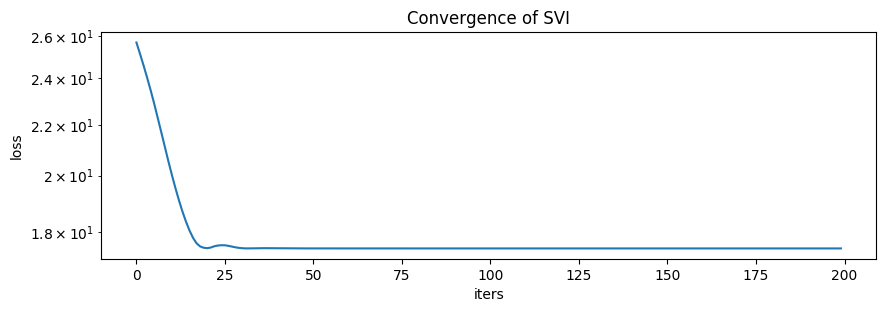

In [15]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [16]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))

weights = [0.375 0.625]


In [17]:
print('locs = {}'.format(locs.data.numpy()))

locs = [ 0.49898112 10.984463  ]


In [18]:
print('scale = {}'.format(scale.data.numpy()))

scale = 0.6514336466789246


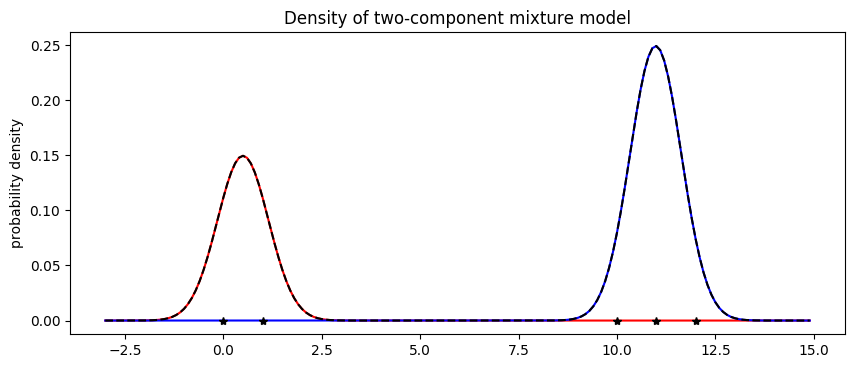

In [19]:
X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())
pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');